In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [2]:
# Analyze to load data in batch
# https://stackoverflow.com/questions/61891990/how-to-load-npy-files-from-different-directories-in-tensorflow-data-pipeline-fr

In [3]:
MAX_CLASSES = 10

In [4]:
data_path = "./data/train_cnn_features_v2"
train_examples = []
train_labels = []
video_categories = listdir(data_path)
for category in video_categories[:MAX_CLASSES]:
    category_path = data_path+"/"+category
    images_files = listdir(category_path)
    for image in images_files:
        image_path = category_path+"/"+image
        cnn_features = np.load(image_path)["arr_0"]
        train_examples.append(cnn_features)
        train_labels.append(category)

In [21]:
MAX_SEQ_LENGTH = 242
NUM_FEATURES = 1280
LEARNING_RATE = 0.001
EPOCHS = 10
BATCH_SIZE = 128
CLASSES = list(set(train_labels))
N_CLASSES = len(CLASSES)
LSTM_1 = 128
LSTM_2 = 64
DENSE_1 = 256
DENSE_2 = 124

In [22]:
N_CLASSES

10

In [23]:
labels_mapping = dict(zip(CLASSES, range(N_CLASSES)))

In [24]:
train_labels_ids = [labels_mapping[case] for case in train_labels]

In [25]:
labels_one_hot = tf.one_hot(train_labels_ids, N_CLASSES)

In [26]:
X_train, X_test, y_train_ids, y_test_ids = train_test_split(train_examples, train_labels_ids, test_size=0.33, random_state=42)

In [27]:
y_train = tf.one_hot(y_train_ids, N_CLASSES)
y_test = tf.one_hot(y_test_ids, N_CLASSES)

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)
#train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, labels_one_hot)).batch(BATCH_SIZE)

In [43]:
model = keras.Sequential()
model.add(keras.Input(shape=(MAX_SEQ_LENGTH, NUM_FEATURES))) 
model.add(LSTM(LSTM_1, dropout=0.2, return_sequences=True))
model.add(LSTM(LSTM_2))
model.add(Dense(DENSE_1))
model.add(Dense(DENSE_2))
model.add(Dense(N_CLASSES, activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 242, 128)          721408    
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 256)               16640     
                                                                 
 dense_10 (Dense)            (None, 124)               31868     
                                                                 
 dense_11 (Dense)            (None, 10)                1250      
                                                                 
Total params: 820,574
Trainable params: 820,574
Non-trainable params: 0
_________________________________________________________________


In [44]:
filepath = "./trained_models/video_classifier_rnn/"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
                                             save_weights_only=True,
                                             save_best_only=True,
                                             verbose=1)
history = model.fit(train_dataset, validation_data=test_dataset, #callbacks=[checkpoint],
                    epochs=EPOCHS)

Epoch 1/10
3/3 [==============================] - 3s 468ms/step - loss: 2.3039 - accuracy: 0.0955 - val_loss: 2.3095 - val_accuracy: 0.0727
Epoch 2/10
3/3 [==============================] - 1s 268ms/step - loss: 2.3001 - accuracy: 0.1134 - val_loss: 2.3159 - val_accuracy: 0.0727
Epoch 3/10
3/3 [==============================] - 1s 266ms/step - loss: 2.2977 - accuracy: 0.1134 - val_loss: 2.3216 - val_accuracy: 0.0727
Epoch 4/10
3/3 [==============================] - 1s 252ms/step - loss: 2.2810 - accuracy: 0.1134 - val_loss: 2.4483 - val_accuracy: 0.0727
Epoch 5/10
3/3 [==============================] - 1s 255ms/step - loss: 2.2544 - accuracy: 0.1552 - val_loss: 2.2977 - val_accuracy: 0.0970
Epoch 6/10
3/3 [==============================] - 1s 252ms/step - loss: 2.2673 - accuracy: 0.1463 - val_loss: 2.2960 - val_accuracy: 0.0970
Epoch 7/10
3/3 [==============================] - 1s 263ms/step - loss: 2.2699 - accuracy: 0.1463 - val_loss: 2.2756 - val_accuracy: 0.0970
Epoch 8/10
3/3 [====

In [45]:
predictions_test = model.predict(np.array(X_test))

In [46]:
predictions_class_test = np.argmax(predictions_test, axis =1)

In [47]:
y_true = y_test_ids
y_pred =  predictions_class_test
# Confusion matrix for actual and predicted values.
cm = confusion_matrix(y_true, y_pred)

In [48]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = CLASSES, 
                     columns = CLASSES)

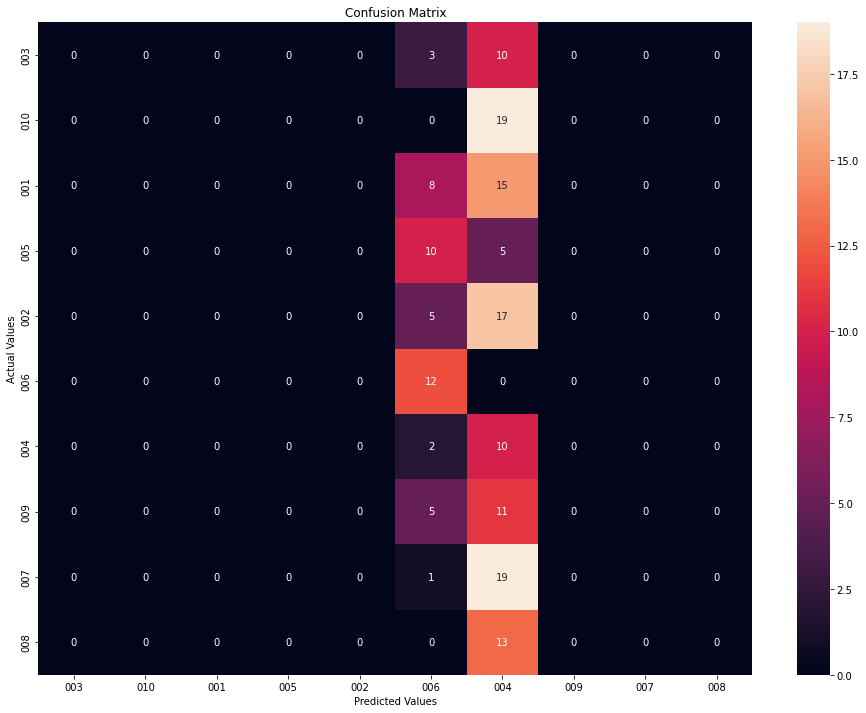

In [49]:
#Plotting the confusion matrix
plt.figure(figsize=(16,12))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
